<a href="https://colab.research.google.com/github/TAnbiR-638/new/blob/main/Msvan_RL_Combo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Upload Data and Install Libraries

# Step 1: Upload your solar_radiation.csv file
from google.colab import files
uploaded = files.upload()

# Verify upload
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

# (No specific libraries to install beyond standard Colab environment for this code)

KeyboardInterrupt: 

In [ ]:
# Cell 2: Imports and Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm # For progress bars in Colab
import math
import io # To read the uploaded file with pandas

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FILE_NAME = 'solar_radiation.csv' # Should match your uploaded file name

SEQ_LENGTH = 72  # Input sequence length (e.g., 6 hours of 5-min data)
PREDICTION_HORIZON = 288 # Output sequence length (24 hours * 12 samples/hour)
BATCH_SIZE = 32 # Adjust based on Colab's GPU memory (16 or 32 often work)
LEARNING_RATE = 1e-4
EPOCHS = 50      # Start with fewer epochs (e.g., 20-30) for faster Colab iterations
HIDDEN_SIZE_LSTM = 64
FDCNN_OUT_CHANNELS = 128
ATTENTION_UNITS = 128
DROPOUT_RATE = 0.2

print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
# Cell 3: Helper Functions

def create_sequences(data, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(len(data) - seq_length - pred_horizon + 1):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length):(i + seq_length + pred_horizon)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

class SolarDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

def calculate_rmse(mse_loss):
    return math.sqrt(mse_loss)

In [ ]:
# Cell 4: Model Components (FFC_block, Attention)

class FFC_block(nn.Module):
    def __init__(self, in_channels, out_channels_total, kernel_size=3, ratio_gin=0.5,
                 stride=1, padding="same", dilation=1, groups=1, bias=False): # Use padding="same"
        super(FFC_block, self).__init__()
        # Ensure out_channels_total is divisible by 2 for splitting
        if out_channels_total % 2 != 0:
            raise ValueError("out_channels_total must be divisible by 2 for FFC block splitting.")

        self.out_channels_part = out_channels_total // 2 # Output channels for local and global part EACH

        in_cg = int(in_channels * ratio_gin)
        in_cl = in_channels - in_cg
        self.ratio_gin = ratio_gin

        # Convolutions for the local path processing contributing to f_l
        self.conv_l2l = nn.Conv1d(in_cl, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)
        # Convolutions for the global path processing contributing to f_l
        self.conv_g2l = nn.Conv1d(in_cg, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)

        # Convolutions for the local path processing contributing to f_g
        self.conv_l2g = nn.Conv1d(in_cl, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)
        # Convolutions for the global path processing contributing to f_g (before FFT)
        self.conv_g2g_pre_fft = nn.Conv1d(in_cg, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)
        # Optional: A conv after IFFT for g2g path if needed, or directly use pre_fft output for FFT
        # self.conv_g2g_post_fft = nn.Conv1d(self.out_channels_part, self.out_channels_part, kernel_size, stride, padding, dilation, groups, bias)


        self.relu = nn.ReLU(inplace=True)

    def forward(self, x): # x: (Batch, In_Channels, SeqLen)
        x_l, x_g = x[:, :int(x.size(1) * (1-self.ratio_gin))], x[:, int(x.size(1) * (1-self.ratio_gin)):]

        # Equation (11) logic: X_local_updated = X_local→local + X_global→local
        f_l_from_local = self.conv_l2l(x_l)
        f_l_from_global = self.conv_g2l(x_g)
        f_l = self.relu(f_l_from_local + f_l_from_global)

        # Equation (12) logic: X_global_updated = X_global→global + X_local→global
        f_g_from_local = self.conv_l2g(x_l)

        # Global path processing for f_g
        f_g_from_global_pre_fft = self.conv_g2g_pre_fft(x_g)

        # Apply FFT, then IFFT.
        # The "learnable" part in frequency domain is tricky.
        # A true FDCNN might have learnable complex weights or separate convolutions for real/imag parts.
        # Here, we simplify: conv -> fft -> (potential learnable scaling/filtering) -> ifft
        # For simplicity, let's assume the main "global" processing is the FFT/IFFT itself on convolved features.
        original_len = f_g_from_global_pre_fft.size(2)
        f_g_fft = torch.fft.rfft(f_g_from_global_pre_fft, dim=2)
        # (Potentially, insert learnable operations on f_g_fft here)
        f_g_ifft = torch.fft.irfft(f_g_fft, n=original_len, dim=2)
        # f_g_from_global = self.relu(self.conv_g2g_post_fft(f_g_ifft)) # If using post_fft conv
        f_g_from_global = f_g_ifft # Directly use ifft output if no post_fft conv

        f_g = self.relu(f_g_from_local + f_g_from_global)

        return torch.cat((f_l, f_g), dim=1) # Concatenate features from local and global updates

class Attention(nn.Module):
    def __init__(self, num_input_channels, seq_len_for_hi, attention_units):
        super(Attention, self).__init__()
        # Input to attention: (Batch, Num_FDCNN_Channels, SeqLen)
        # 'hi' is a channel vector of length 'seq_len_for_hi'.
        # Wh maps each 'hi' (a channel vector) to 'attention_units'.
        self.fc_for_aei = nn.Linear(seq_len_for_hi, attention_units) # W_h * h_i part
        self.Wh_att_score = nn.Linear(attention_units, 1) # To get a single score per channel for softmax

    def forward(self, x): # x: (Batch, Num_FDCNN_Channels, SeqLen)
        batch_size, num_fdcnn_channels, seq_len = x.shape

        ae_scores_list = []
        for i in range(num_fdcnn_channels):
            hi = x[:, i, :]  # (Batch, SeqLen) - this is one channel vector

            # Eq 13: aei = max(0, Whi hi + bh)
            # Assuming bh is absorbed or not explicitly used for simplicity like some attention heads
            aei_processed = self.fc_for_aei(hi) # (Batch, attention_units)
            aei_activated = torch.relu(aei_processed) # (Batch, attention_units)

            # Get a single score for this channel
            score_for_channel_i = self.Wh_att_score(aei_activated).squeeze(-1) # (Batch)
            ae_scores_list.append(score_for_channel_i)

        ae_T_scores = torch.stack(ae_scores_list, dim=1) # (Batch, Num_FDCNN_Channels)

        # Eq 14: ari = softmax(aei)
        ari_weights = torch.softmax(ae_T_scores, dim=1) # (Batch, Num_FDCNN_Channels)

        # Eq 15: asi = Σ arj hj
        # ari_weights: (Batch, Num_FDCNN_Channels)
        # x: (Batch, Num_FDCNN_Channels, SeqLen)
        # We need to expand ari_weights for element-wise multiplication
        # (Batch, Num_FDCNN_Channels, 1) * (Batch, Num_FDCNN_Channels, SeqLen)
        context_vector = torch.sum(ari_weights.unsqueeze(-1) * x, dim=1) # (Batch, SeqLen)

        return context_vector, ari_weights

In [ ]:
# Cell 5: MSMVAN_Univariate Model Definition

class MSMVAN_Univariate(nn.Module):
    def __init__(self, input_size, hidden_size_lstm, lstm_layers, ffc_out_channels_total,
                 attention_units, pred_horizon, seq_len, dropout_rate=0.2):
        super(MSMVAN_Univariate, self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size, hidden_size_lstm, num_layers=lstm_layers,
                            batch_first=True, bidirectional=True,
                            dropout=dropout_rate if lstm_layers > 1 else 0)

        bilstm_out_features = hidden_size_lstm * 2

        # FFC block input channels = bilstm_out_features
        # FFC block output channels = ffc_out_channels_total
        self.ffc1 = FFC_block(bilstm_out_features, ffc_out_channels_total, kernel_size=3, padding="same")
        # self.ffc2 = FFC_block(ffc_out_channels_total, ffc_out_channels_total, kernel_size=3, padding="same") # Optional

        # Attention input: (Batch, ffc_out_channels_total, SeqLen)
        # 'hi' for attention is a channel vector of length SeqLen
        self.attention = Attention(
            num_input_channels=ffc_out_channels_total, # Number of channels from FFC
            seq_len_for_hi=seq_len, # Length of each channel vector
            attention_units=attention_units
        )

        self.dropout = nn.Dropout(dropout_rate)
        # Input to fc is attention output (Batch, SeqLen)
        self.fc = nn.Linear(seq_len, pred_horizon)

    def forward(self, x): # x: (Batch, SeqLen, Input_Size=1 for univariate)
        lstm_out, _ = self.lstm(x) # (Batch, SeqLen, Hidden*2)

        # Prepare for FFC: (Batch, Channels=Hidden*2, SeqLen)
        ffc_in = lstm_out.permute(0, 2, 1)

        ffc_out = self.ffc1(ffc_in)
        # ffc_out = self.ffc2(ffc_out) # If using second FFC

        # ffc_out is (Batch, ffc_out_channels_total, SeqLen)
        attn_out_context_vector, attn_weights = self.attention(ffc_out) # attn_out_context_vector: (Batch, SeqLen)

        dropped_out = self.dropout(attn_out_context_vector)
        predictions = self.fc(dropped_out) # (Batch, PredHorizon)
        return predictions

In [ ]:
# Cell 6: Data Loading and Preprocessing

# Read the uploaded file
try:
    df = pd.read_csv(io.BytesIO(uploaded[FILE_NAME]), usecols=['Solar_Radiation'])
    print(f"Successfully loaded {FILE_NAME}")
except KeyError:
    print(f"Error: File '{FILE_NAME}' not found in upload or 'Solar_Radiation' column missing.")
    # Fallback to dummy data if file loading fails, for testing the rest of the script
    print("Generating dummy data as fallback.")
    data_raw = np.sin(np.linspace(0, 1000, 33133)) * 50 + 50
    data_raw += np.random.normal(0, 5, 33133)
    data_raw = np.clip(data_raw, 0, None)
else:
    # Ensure 'Solar_Radiation' is numeric. If already numeric, this won't harm.
    df['Solar_Radiation'] = pd.to_numeric(df['Solar_Radiation'], errors='coerce')
    # The problem states "no null value", but this is good practice.
    # If coerce creates NaNs for some reason, drop them.
    df.dropna(subset=['Solar_Radiation'], inplace=True)
    data_raw = df['Solar_Radiation'].values.astype(float)

if len(data_raw) < SEQ_LENGTH + PREDICTION_HORIZON:
    raise ValueError(f"Not enough data points ({len(data_raw)}) for the given SEQ_LENGTH ({SEQ_LENGTH}) and PREDICTION_HORIZON ({PREDICTION_HORIZON}).")

print(f"Raw data shape: {data_raw.shape}")

scaler = MinMaxScaler(feature_range=(-1, 1)) # Or (0,1) if solar radiation is always non-negative
data_scaled = scaler.fit_transform(data_raw.reshape(-1, 1))

features, targets = create_sequences(data_scaled, SEQ_LENGTH, PREDICTION_HORIZON)
features = features.reshape(features.shape[0], SEQ_LENGTH, 1) # Add feature dim for univariate

print(f"Features shape: {features.shape}, Targets shape: {targets.shape}")

# Split data (e.g., 80% train, 10% val, 10% test)
# Ensure enough samples for each split after sequence creation
if len(features) < 10: # Arbitrary small number, adjust if needed
    raise ValueError(f"Too few sequences ({len(features)}) created. Check data length, SEQ_LENGTH, and PREDICTION_HORIZON.")

train_ratio = 0.8
val_ratio = 0.1
# test_ratio = 0.1 # Implicit

train_size = int(len(features) * train_ratio)
val_size = int(len(features) * val_ratio)
# test_size = len(features) - train_size - val_size # The rest is test

train_features, train_targets = features[:train_size], targets[:train_size]
val_features, val_targets = features[train_size:train_size+val_size], targets[train_size:train_size+val_size]
test_features, test_targets = features[train_size+val_size:], targets[train_size+val_size:]

print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")


# Create DataLoaders
if len(train_features) > 0:
    train_dataset = SolarDataset(train_features, train_targets)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
else:
    train_loader = None
    print("Warning: Training set is empty after splitting.")

if len(val_features) > 0:
    val_dataset = SolarDataset(val_features, val_targets)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
else:
    val_loader = None
    print("Warning: Validation set is empty after splitting.")

if len(test_features) > 0:
    test_dataset = SolarDataset(test_features, test_targets)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
else:
    test_loader = None
    print("Warning: Test set is empty after splitting.")


if not train_loader:
    raise ValueError("Training DataLoader could not be created. Check data and split sizes.")

Successfully loaded solar_radiation.csv
Raw data shape: (33133,)
Features shape: (32774, 72, 1), Targets shape: (32774, 288, 1)
Train features shape: (26219, 72, 1)
Validation features shape: (3277, 72, 1)
Test features shape: (3278, 72, 1)


In [ ]:
# Cell 7: Model Initialization, Optimizer, Criterion, Scheduler

model = MSMVAN_Univariate(
    input_size=1, # Univariate
    hidden_size_lstm=HIDDEN_SIZE_LSTM,
    lstm_layers=2, # Example, can be tuned
    ffc_out_channels_total=FDCNN_OUT_CHANNELS,
    attention_units=ATTENTION_UNITS,
    pred_horizon=PREDICTION_HORIZON,
    seq_len=SEQ_LENGTH,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True) # Reduced patience

print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

MSMVAN_Univariate(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (ffc1): FFC_block(
    (conv_l2l): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (conv_g2l): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (conv_l2g): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (conv_g2g_pre_fft): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (relu): ReLU(inplace=True)
  )
  (attention): Attention(
    (fc_for_aei): Linear(in_features=72, out_features=128, bias=True)
    (Wh_att_score): Linear(in_features=128, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=72, out_features=288, bias=True)
)
Total trainable parameters: 213281


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.83batch/s, MAE=0.296, MSE=0.11]



Epoch 1/50 Summary:
  LR: 0.000100
  Train MSE: 0.241973, RMSE: 0.491907, MAE: 0.403872
  Val   MSE: 0.138291, RMSE: 0.371875, MAE: 0.334554
  >>> New best validation MSE: 0.138291. Model saved. <<<
--------------------------------------------------


Epoch 2/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.94batch/s, MAE=0.298, MSE=0.109]



Epoch 2/50 Summary:
  LR: 0.000100
  Train MSE: 0.180465, RMSE: 0.424811, MAE: 0.352572
  Val   MSE: 0.139504, RMSE: 0.373502, MAE: 0.338626
--------------------------------------------------


Epoch 3/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.94batch/s, MAE=0.269, MSE=0.097]



Epoch 3/50 Summary:
  LR: 0.000100
  Train MSE: 0.176446, RMSE: 0.420054, MAE: 0.349212
  Val   MSE: 0.134132, RMSE: 0.366241, MAE: 0.320696
  >>> New best validation MSE: 0.134132. Model saved. <<<
--------------------------------------------------


Epoch 4/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.58batch/s, MAE=0.272, MSE=0.0955]



Epoch 4/50 Summary:
  LR: 0.000100
  Train MSE: 0.172033, RMSE: 0.414769, MAE: 0.343871
  Val   MSE: 0.124553, RMSE: 0.352921, MAE: 0.304010
  >>> New best validation MSE: 0.124553. Model saved. <<<
--------------------------------------------------


Epoch 5/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.17batch/s, MAE=0.246, MSE=0.0997]



Epoch 5/50 Summary:
  LR: 0.000100
  Train MSE: 0.122974, RMSE: 0.350676, MAE: 0.276277
  Val   MSE: 0.073473, RMSE: 0.271058, MAE: 0.208472
  >>> New best validation MSE: 0.073473. Model saved. <<<
--------------------------------------------------


Epoch 6/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.98batch/s, MAE=0.259, MSE=0.109]



Epoch 6/50 Summary:
  LR: 0.000100
  Train MSE: 0.092070, RMSE: 0.303430, MAE: 0.234697
  Val   MSE: 0.070698, RMSE: 0.265890, MAE: 0.199936
  >>> New best validation MSE: 0.070698. Model saved. <<<
--------------------------------------------------


Epoch 7/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.54batch/s, MAE=0.247, MSE=0.107]



Epoch 7/50 Summary:
  LR: 0.000100
  Train MSE: 0.084608, RMSE: 0.290875, MAE: 0.222761
  Val   MSE: 0.066043, RMSE: 0.256988, MAE: 0.185095
  >>> New best validation MSE: 0.066043. Model saved. <<<
--------------------------------------------------


Epoch 8/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 15.95batch/s, MAE=0.217, MSE=0.0952]



Epoch 8/50 Summary:
  LR: 0.000100
  Train MSE: 0.078382, RMSE: 0.279967, MAE: 0.210387
  Val   MSE: 0.060649, RMSE: 0.246271, MAE: 0.166416
  >>> New best validation MSE: 0.060649. Model saved. <<<
--------------------------------------------------


Epoch 9/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.56batch/s, MAE=0.195, MSE=0.0863]



Epoch 9/50 Summary:
  LR: 0.000100
  Train MSE: 0.074289, RMSE: 0.272559, MAE: 0.201599
  Val   MSE: 0.057843, RMSE: 0.240506, MAE: 0.159078
  >>> New best validation MSE: 0.057843. Model saved. <<<
--------------------------------------------------


Epoch 10/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.95batch/s, MAE=0.197, MSE=0.088]



Epoch 10/50 Summary:
  LR: 0.000100
  Train MSE: 0.071368, RMSE: 0.267148, MAE: 0.195489
  Val   MSE: 0.057513, RMSE: 0.239819, MAE: 0.157854
  >>> New best validation MSE: 0.057513. Model saved. <<<
--------------------------------------------------


Epoch 11/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.78batch/s, MAE=0.222, MSE=0.106]



Epoch 11/50 Summary:
  LR: 0.000100
  Train MSE: 0.070152, RMSE: 0.264861, MAE: 0.192600
  Val   MSE: 0.059081, RMSE: 0.243066, MAE: 0.157006
--------------------------------------------------


Epoch 12/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.00batch/s, MAE=0.216, MSE=0.099]



Epoch 12/50 Summary:
  LR: 0.000100
  Train MSE: 0.068833, RMSE: 0.262360, MAE: 0.189880
  Val   MSE: 0.058612, RMSE: 0.242099, MAE: 0.155386
--------------------------------------------------


Epoch 13/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.98batch/s, MAE=0.199, MSE=0.0943]



Epoch 13/50 Summary:
  LR: 0.000100
  Train MSE: 0.067540, RMSE: 0.259885, MAE: 0.187141
  Val   MSE: 0.055362, RMSE: 0.235291, MAE: 0.147248
  >>> New best validation MSE: 0.055362. Model saved. <<<
--------------------------------------------------


Epoch 14/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.55batch/s, MAE=0.224, MSE=0.102]



Epoch 14/50 Summary:
  LR: 0.000100
  Train MSE: 0.066382, RMSE: 0.257647, MAE: 0.184687
  Val   MSE: 0.055990, RMSE: 0.236621, MAE: 0.159092
--------------------------------------------------


Epoch 15/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.84batch/s, MAE=0.194, MSE=0.0884]



Epoch 15/50 Summary:
  LR: 0.000100
  Train MSE: 0.065418, RMSE: 0.255770, MAE: 0.182708
  Val   MSE: 0.055280, RMSE: 0.235117, MAE: 0.149992
  >>> New best validation MSE: 0.055280. Model saved. <<<
--------------------------------------------------


Epoch 16/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.47batch/s, MAE=0.21, MSE=0.101]



Epoch 16/50 Summary:
  LR: 0.000100
  Train MSE: 0.064712, RMSE: 0.254386, MAE: 0.181436
  Val   MSE: 0.056532, RMSE: 0.237765, MAE: 0.154319
--------------------------------------------------


Epoch 17/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 17.09batch/s, MAE=0.197, MSE=0.0956]



Epoch 17/50 Summary:
  LR: 0.000100
  Train MSE: 0.064393, RMSE: 0.253757, MAE: 0.180377
  Val   MSE: 0.055035, RMSE: 0.234596, MAE: 0.146154
  >>> New best validation MSE: 0.055035. Model saved. <<<
--------------------------------------------------


Epoch 18/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.31batch/s, MAE=0.203, MSE=0.0956]



Epoch 18/50 Summary:
  LR: 0.000100
  Train MSE: 0.063724, RMSE: 0.252437, MAE: 0.178983
  Val   MSE: 0.056226, RMSE: 0.237121, MAE: 0.151422
--------------------------------------------------


Epoch 19/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.84batch/s, MAE=0.194, MSE=0.0873]



Epoch 19/50 Summary:
  LR: 0.000100
  Train MSE: 0.063242, RMSE: 0.251479, MAE: 0.177999
  Val   MSE: 0.051774, RMSE: 0.227539, MAE: 0.144497
  >>> New best validation MSE: 0.051774. Model saved. <<<
--------------------------------------------------


Epoch 20/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 17.17batch/s, MAE=0.208, MSE=0.0979]



Epoch 20/50 Summary:
  LR: 0.000100
  Train MSE: 0.062581, RMSE: 0.250162, MAE: 0.176424
  Val   MSE: 0.053329, RMSE: 0.230932, MAE: 0.148661
--------------------------------------------------


Epoch 21/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.55batch/s, MAE=0.207, MSE=0.0962]



Epoch 21/50 Summary:
  LR: 0.000100
  Train MSE: 0.062947, RMSE: 0.250892, MAE: 0.176857
  Val   MSE: 0.054693, RMSE: 0.233865, MAE: 0.149763
--------------------------------------------------


Epoch 22/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.16batch/s, MAE=0.189, MSE=0.0741]



Epoch 22/50 Summary:
  LR: 0.000100
  Train MSE: 0.062097, RMSE: 0.249193, MAE: 0.175473
  Val   MSE: 0.050093, RMSE: 0.223814, MAE: 0.146592
  >>> New best validation MSE: 0.050093. Model saved. <<<
--------------------------------------------------


Epoch 23/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 17.66batch/s, MAE=0.187, MSE=0.0866]



Epoch 23/50 Summary:
  LR: 0.000100
  Train MSE: 0.061286, RMSE: 0.247561, MAE: 0.173711
  Val   MSE: 0.052539, RMSE: 0.229213, MAE: 0.142913
--------------------------------------------------


Epoch 24/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.91batch/s, MAE=0.205, MSE=0.0901]



Epoch 24/50 Summary:
  LR: 0.000100
  Train MSE: 0.061322, RMSE: 0.247633, MAE: 0.173792
  Val   MSE: 0.051521, RMSE: 0.226983, MAE: 0.146359
--------------------------------------------------


Epoch 25/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.72batch/s, MAE=0.212, MSE=0.106]



Epoch 25/50 Summary:
  LR: 0.000100
  Train MSE: 0.060878, RMSE: 0.246734, MAE: 0.172799
  Val   MSE: 0.054182, RMSE: 0.232771, MAE: 0.147272
--------------------------------------------------


Epoch 26/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.65batch/s, MAE=0.202, MSE=0.0799]



Epoch 26/50 Summary:
  LR: 0.000100
  Train MSE: 0.060415, RMSE: 0.245794, MAE: 0.171906
  Val   MSE: 0.049733, RMSE: 0.223009, MAE: 0.145479
  >>> New best validation MSE: 0.049733. Model saved. <<<
--------------------------------------------------


Epoch 27/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.81batch/s, MAE=0.215, MSE=0.109]



Epoch 27/50 Summary:
  LR: 0.000100
  Train MSE: 0.060434, RMSE: 0.245832, MAE: 0.171691
  Val   MSE: 0.054422, RMSE: 0.233286, MAE: 0.142760
--------------------------------------------------


Epoch 28/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.70batch/s, MAE=0.194, MSE=0.0965]



Epoch 28/50 Summary:
  LR: 0.000100
  Train MSE: 0.059900, RMSE: 0.244745, MAE: 0.170962
  Val   MSE: 0.053728, RMSE: 0.231794, MAE: 0.144270
--------------------------------------------------


Epoch 29/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.91batch/s, MAE=0.215, MSE=0.101]



Epoch 29/50 Summary:
  LR: 0.000100
  Train MSE: 0.059657, RMSE: 0.244248, MAE: 0.170247
  Val   MSE: 0.056378, RMSE: 0.237441, MAE: 0.154922
--------------------------------------------------


Epoch 30/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.33batch/s, MAE=0.181, MSE=0.0853]



Epoch 30/50 Summary:
  LR: 0.000100
  Train MSE: 0.058830, RMSE: 0.242549, MAE: 0.169041
  Val   MSE: 0.052467, RMSE: 0.229057, MAE: 0.141108
--------------------------------------------------


Epoch 31/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.25batch/s, MAE=0.18, MSE=0.0849]



Epoch 31/50 Summary:
  LR: 0.000050
  Train MSE: 0.057601, RMSE: 0.240002, MAE: 0.166375
  Val   MSE: 0.051226, RMSE: 0.226332, MAE: 0.136567
--------------------------------------------------


Epoch 32/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.31batch/s, MAE=0.181, MSE=0.0796]



Epoch 32/50 Summary:
  LR: 0.000050
  Train MSE: 0.056848, RMSE: 0.238428, MAE: 0.165113
  Val   MSE: 0.051529, RMSE: 0.227001, MAE: 0.141418
--------------------------------------------------


Epoch 33/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.92batch/s, MAE=0.182, MSE=0.0812]



Epoch 33/50 Summary:
  LR: 0.000050
  Train MSE: 0.056998, RMSE: 0.238742, MAE: 0.165427
  Val   MSE: 0.048650, RMSE: 0.220568, MAE: 0.137967
  >>> New best validation MSE: 0.048650. Model saved. <<<
--------------------------------------------------


Epoch 34/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 17.25batch/s, MAE=0.18, MSE=0.0797]



Epoch 34/50 Summary:
  LR: 0.000050
  Train MSE: 0.056685, RMSE: 0.238086, MAE: 0.164893
  Val   MSE: 0.049198, RMSE: 0.221806, MAE: 0.138649
--------------------------------------------------


Epoch 35/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.30batch/s, MAE=0.181, MSE=0.0813]



Epoch 35/50 Summary:
  LR: 0.000050
  Train MSE: 0.056330, RMSE: 0.237339, MAE: 0.163930
  Val   MSE: 0.048410, RMSE: 0.220022, MAE: 0.135927
  >>> New best validation MSE: 0.048410. Model saved. <<<
--------------------------------------------------


Epoch 36/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 20.28batch/s, MAE=0.205, MSE=0.0884]



Epoch 36/50 Summary:
  LR: 0.000050
  Train MSE: 0.056310, RMSE: 0.237297, MAE: 0.163840
  Val   MSE: 0.053070, RMSE: 0.230370, MAE: 0.148241
--------------------------------------------------


Epoch 37/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 20.19batch/s, MAE=0.187, MSE=0.0855]



Epoch 37/50 Summary:
  LR: 0.000050
  Train MSE: 0.060167, RMSE: 0.245290, MAE: 0.166698
  Val   MSE: 0.049669, RMSE: 0.222865, MAE: 0.140360
--------------------------------------------------


Epoch 38/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 20.10batch/s, MAE=0.194, MSE=0.093]



Epoch 38/50 Summary:
  LR: 0.000050
  Train MSE: 0.056079, RMSE: 0.236810, MAE: 0.163598
  Val   MSE: 0.050966, RMSE: 0.225758, MAE: 0.139390
--------------------------------------------------


Epoch 39/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.83batch/s, MAE=0.19, MSE=0.0931]



Epoch 39/50 Summary:
  LR: 0.000050
  Train MSE: 0.056072, RMSE: 0.236794, MAE: 0.163526
  Val   MSE: 0.053854, RMSE: 0.232065, MAE: 0.141511
--------------------------------------------------


Epoch 40/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.76batch/s, MAE=0.177, MSE=0.0839]



Epoch 40/50 Summary:
  LR: 0.000025
  Train MSE: 0.055327, RMSE: 0.235216, MAE: 0.162084
  Val   MSE: 0.049271, RMSE: 0.221970, MAE: 0.134128
--------------------------------------------------


Epoch 41/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.98batch/s, MAE=0.174, MSE=0.0841]



Epoch 41/50 Summary:
  LR: 0.000025
  Train MSE: 0.055300, RMSE: 0.235160, MAE: 0.162067
  Val   MSE: 0.050664, RMSE: 0.225086, MAE: 0.133916
--------------------------------------------------


Epoch 42/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.79batch/s, MAE=0.174, MSE=0.0813]



Epoch 42/50 Summary:
  LR: 0.000025
  Train MSE: 0.055104, RMSE: 0.234743, MAE: 0.161642
  Val   MSE: 0.048682, RMSE: 0.220641, MAE: 0.134128
--------------------------------------------------


Epoch 43/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.77batch/s, MAE=0.171, MSE=0.0815]



Epoch 43/50 Summary:
  LR: 0.000025
  Train MSE: 0.055009, RMSE: 0.234541, MAE: 0.161655
  Val   MSE: 0.049011, RMSE: 0.221384, MAE: 0.134331
--------------------------------------------------


Epoch 44/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.84batch/s, MAE=0.182, MSE=0.0913]



Epoch 44/50 Summary:
  LR: 0.000013
  Train MSE: 0.054513, RMSE: 0.233481, MAE: 0.160612
  Val   MSE: 0.050252, RMSE: 0.224170, MAE: 0.133188
--------------------------------------------------


Epoch 45/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.32batch/s, MAE=0.172, MSE=0.0843]



Epoch 45/50 Summary:
  LR: 0.000013
  Train MSE: 0.054378, RMSE: 0.233191, MAE: 0.160377
  Val   MSE: 0.049853, RMSE: 0.223277, MAE: 0.133583
--------------------------------------------------


Epoch 46/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 19.59batch/s, MAE=0.174, MSE=0.0848]



Epoch 46/50 Summary:
  LR: 0.000013
  Train MSE: 0.054344, RMSE: 0.233117, MAE: 0.160358
  Val   MSE: 0.050066, RMSE: 0.223753, MAE: 0.133958
--------------------------------------------------


Epoch 47/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.31batch/s, MAE=0.179, MSE=0.0894]



Epoch 47/50 Summary:
  LR: 0.000013
  Train MSE: 0.054246, RMSE: 0.232908, MAE: 0.160047
  Val   MSE: 0.050047, RMSE: 0.223711, MAE: 0.134679
--------------------------------------------------


Epoch 48/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 18.30batch/s, MAE=0.174, MSE=0.085]



Epoch 48/50 Summary:
  LR: 0.000006
  Train MSE: 0.053924, RMSE: 0.232215, MAE: 0.159628
  Val   MSE: 0.048902, RMSE: 0.221138, MAE: 0.131556
--------------------------------------------------


Epoch 49/50 [Validation]: 100%|██████████| 102/102 [00:05<00:00, 17.91batch/s, MAE=0.172, MSE=0.083]



Epoch 49/50 Summary:
  LR: 0.000006
  Train MSE: 0.054074, RMSE: 0.232539, MAE: 0.159829
  Val   MSE: 0.048569, RMSE: 0.220384, MAE: 0.132776
--------------------------------------------------


Epoch 50/50 [Validation]: 100%|██████████| 102/102 [00:06<00:00, 16.68batch/s, MAE=0.174, MSE=0.085]



Epoch 50/50 Summary:
  LR: 0.000006
  Train MSE: 0.054090, RMSE: 0.232572, MAE: 0.159686
  Val   MSE: 0.048831, RMSE: 0.220978, MAE: 0.131811
--------------------------------------------------

--- Training Finished ---
Best Validation MSE: 0.048410
Best Validation RMSE: 0.220022
Best Validation MAE: 0.135927


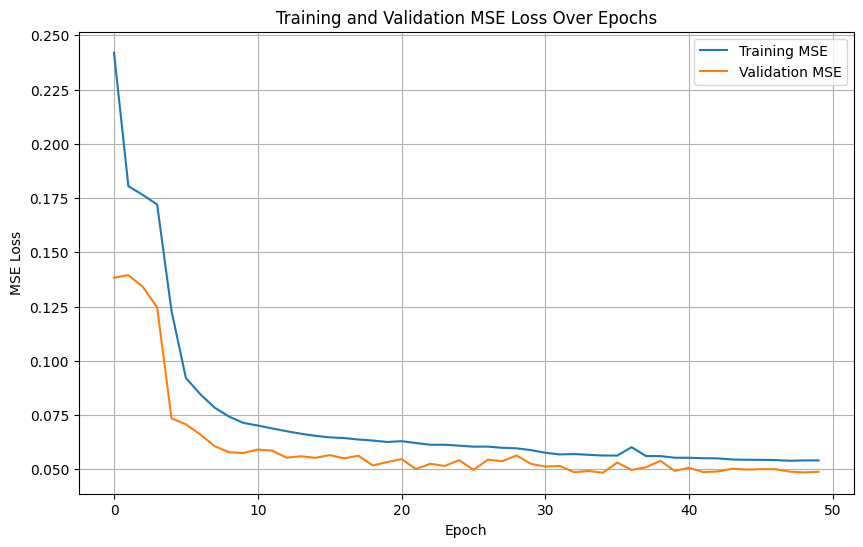

In [ ]:
# Cell 8: Training Loop

best_val_mse = float('inf')
best_val_rmse = float('inf')
best_val_mae = float('inf')

train_mse_history = []
val_mse_history = []

if not train_loader or not val_loader:
    print("Skipping training as train_loader or val_loader is not available.")
else:
    for epoch in range(EPOCHS):
        model.train()
        epoch_train_mse_loss = 0
        epoch_train_mae_loss = 0

        # Using tqdm for progress bar in Colab
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", unit="batch")
        for batch_features, batch_targets in train_pbar:
            batch_features, batch_targets = batch_features.to(DEVICE), batch_targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(batch_features) # Shape: (Batch, PredHorizon)

            # Ensure targets are (Batch, PredHorizon) for loss calculation
            if batch_targets.ndim == 3 and batch_targets.shape[-1] == 1: # (B, Horizon, 1)
                batch_targets_squeezed = batch_targets.squeeze(-1)
            elif batch_targets.ndim == 2: # (B, Horizon)
                batch_targets_squeezed = batch_targets
            else:
                raise ValueError(f"Unexpected target shape: {batch_targets.shape}")

            loss_mse = criterion(outputs, batch_targets_squeezed)
            loss_mae = nn.L1Loss()(outputs, batch_targets_squeezed)

            loss_mse.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()

            epoch_train_mse_loss += loss_mse.item()
            epoch_train_mae_loss += loss_mae.item()
            train_pbar.set_postfix(MSE=loss_mse.item(), MAE=loss_mae.item())

        avg_epoch_train_mse = epoch_train_mse_loss / len(train_loader)
        avg_epoch_train_rmse = calculate_rmse(avg_epoch_train_mse)
        avg_epoch_train_mae = epoch_train_mae_loss / len(train_loader)
        train_mse_history.append(avg_epoch_train_mse)

        # Validation
        model.eval()
        epoch_val_mse_loss = 0
        epoch_val_mae_loss = 0

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]", unit="batch")
        with torch.no_grad():
            for batch_features, batch_targets in val_pbar:
                batch_features, batch_targets = batch_features.to(DEVICE), batch_targets.to(DEVICE)
                outputs = model(batch_features)

                if batch_targets.ndim == 3 and batch_targets.shape[-1] == 1:
                    batch_targets_squeezed = batch_targets.squeeze(-1)
                else:
                    batch_targets_squeezed = batch_targets

                loss_mse = criterion(outputs, batch_targets_squeezed)
                loss_mae = nn.L1Loss()(outputs, batch_targets_squeezed)
                epoch_val_mse_loss += loss_mse.item()
                epoch_val_mae_loss += loss_mae.item()
                val_pbar.set_postfix(MSE=loss_mse.item(), MAE=loss_mae.item())

        avg_epoch_val_mse = epoch_val_mse_loss / len(val_loader)
        avg_epoch_val_rmse = calculate_rmse(avg_epoch_val_mse)
        avg_epoch_val_mae = epoch_val_mae_loss / len(val_loader)
        val_mse_history.append(avg_epoch_val_mse)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:"
              f"\n  LR: {current_lr:.6f}"
              f"\n  Train MSE: {avg_epoch_train_mse:.6f}, RMSE: {avg_epoch_train_rmse:.6f}, MAE: {avg_epoch_train_mae:.6f}"
              f"\n  Val   MSE: {avg_epoch_val_mse:.6f}, RMSE: {avg_epoch_val_rmse:.6f}, MAE: {avg_epoch_val_mae:.6f}")

        scheduler.step(avg_epoch_val_mse)

        if avg_epoch_val_mse < best_val_mse:
            best_val_mse = avg_epoch_val_mse
            best_val_rmse = avg_epoch_val_rmse
            best_val_mae = avg_epoch_val_mae
            torch.save(model.state_dict(), 'best_msmvan_colab_model.pth')
            print(f"  >>> New best validation MSE: {best_val_mse:.6f}. Model saved. <<<")
        print("-" * 50)

print("\n--- Training Finished ---")
print(f"Best Validation MSE: {best_val_mse:.6f}")
print(f"Best Validation RMSE: {best_val_rmse:.6f}")
print(f"Best Validation MAE: {best_val_mae:.6f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_mse_history, label='Training MSE')
plt.plot(val_mse_history, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("msmvan_training_validation_loss.png")
plt.show()


--- Predicted Solar Radiation for Next 24 Hours (5-min intervals) ---
     Time_Step (5-min)  Predicted_Solar_Radiation
0                    1                   6.199426
1                    2                   6.696385
2                    3                  10.646541
3                    4                  11.788815
4                    5                  14.539995
..                 ...                        ...
283                284                  18.191051
284                285                  19.007998
285                286                  20.197578
286                287                  22.845512
287                288                  22.802450

[288 rows x 2 columns]

Predicted 24h data saved to 'predicted_24h_solar_radiation.csv'

--- Illustrative: Validation Loss for Various Window Sizes ---
Illustrative Val MSE for window size 24: 0.0645 (Dummy value)
Illustrative Val MSE for window size 48: 0.0565 (Dummy value)
Illustrative Val MSE for window size 96: 0.0565 (Dum

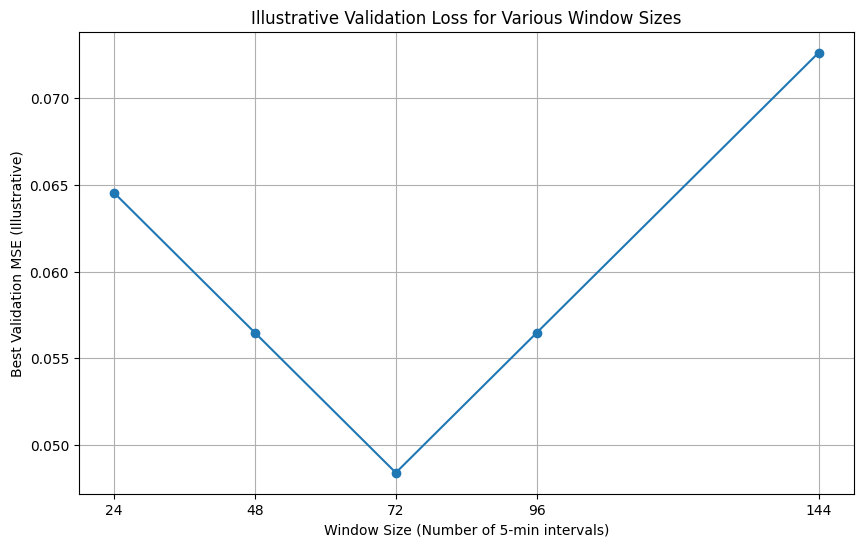

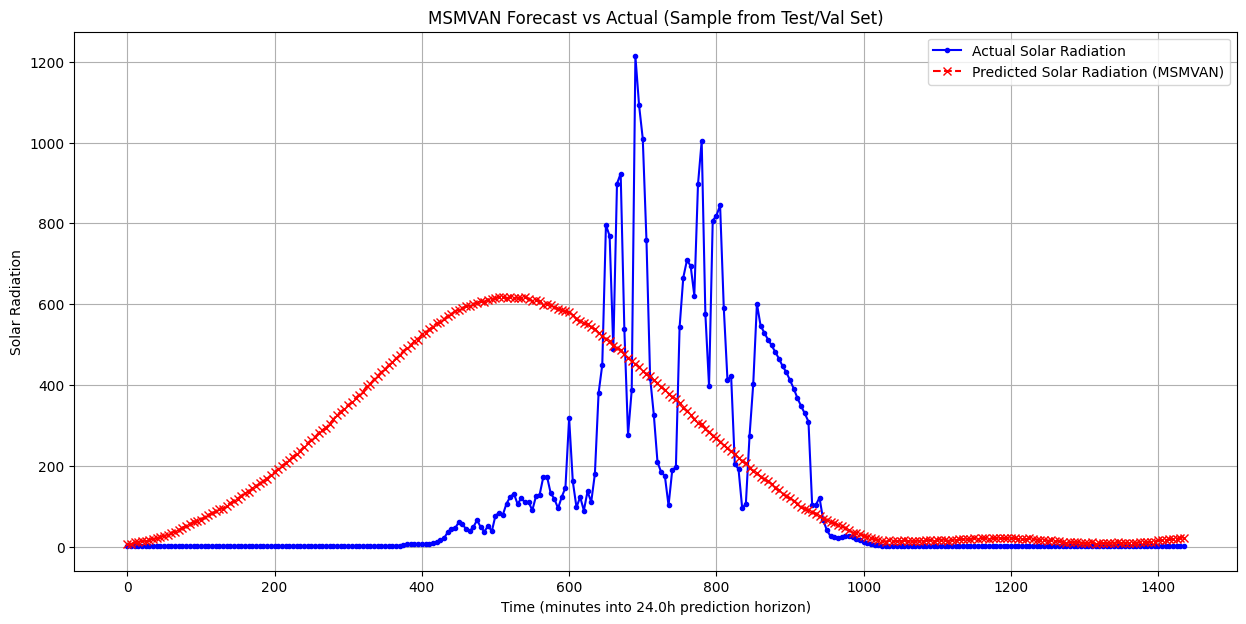

In [ ]:
# Cell 9: Prediction for Next 24 Hours and Evaluation Plots

# Load the best model
model.load_state_dict(torch.load('best_msmvan_colab_model.pth'))
model.eval()

# --- Prediction for next 24 hours ---
# Take the last sequence from the original (scaled) data to predict
last_sequence_scaled = data_scaled[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1) # (1, SeqLen, 1)
last_sequence_tensor = torch.tensor(last_sequence_scaled, dtype=torch.float32).to(DEVICE)

with torch.no_grad():
    predicted_scaled_24h = model(last_sequence_tensor).cpu().numpy().flatten() # (PredHorizon,)

# Inverse transform the prediction
predicted_actual_24h = scaler.inverse_transform(predicted_scaled_24h.reshape(-1, 1)).flatten()

print("\n--- Predicted Solar Radiation for Next 24 Hours (5-min intervals) ---")
predicted_df = pd.DataFrame({'Time_Step (5-min)': range(1, PREDICTION_HORIZON + 1),
                             'Predicted_Solar_Radiation': predicted_actual_24h})
print(predicted_df)
predicted_df.to_csv("predicted_24h_solar_radiation.csv", index=False)
print("\nPredicted 24h data saved to 'predicted_24h_solar_radiation.csv'")


# --- Validation Loss for Various Window Sizes (Illustrative as in paper) ---
print("\n--- Illustrative: Validation Loss for Various Window Sizes ---")
# This part is complex as it ideally requires re-training for each window size.
# We'll create a conceptual plot based on the current model's performance for its window size.
window_sizes_to_test = [24, 48, SEQ_LENGTH, 96, 144] # e.g., 2h, 4h, current, 8h, 12h
val_losses_for_windows = {}

for ws in window_sizes_to_test:
    if ws == SEQ_LENGTH:
         val_losses_for_windows[ws] = best_val_mse if best_val_mse != float('inf') else (val_mse_history[-1] if val_mse_history else 0.1)
    else:
        # For other window sizes, we'd typically re-train.
        # Here, we'll use a placeholder value for illustration.
        # A more realistic dummy would be higher loss for very small/large windows.
        base_loss = best_val_mse if best_val_mse != float('inf') else 0.1
        deviation = abs(ws - SEQ_LENGTH) / SEQ_LENGTH # Normalized deviation
        val_losses_for_windows[ws] = base_loss * (1 + deviation * 0.5) # Dummy loss
        print(f"Illustrative Val MSE for window size {ws}: {val_losses_for_windows[ws]:.4f} (Dummy value)")


if val_losses_for_windows:
    plt.figure(figsize=(10, 6))
    sorted_windows = sorted(val_losses_for_windows.keys())
    sorted_losses = [val_losses_for_windows[w] for w in sorted_windows]
    plt.plot(sorted_windows, sorted_losses, marker='o', linestyle='-')
    plt.xlabel("Window Size (Number of 5-min intervals)")
    plt.ylabel("Best Validation MSE (Illustrative)")
    plt.title("Illustrative Validation Loss for Various Window Sizes")
    plt.grid(True)
    plt.xticks(window_sizes_to_test)
    plt.savefig("msmvan_val_loss_window_sizes_colab.png")
    plt.show()


# --- Plot Proposed Model Forecast vs Actual (on a segment of test/val data) ---
# Use a segment of test_loader or val_loader for this plot
plot_loader = test_loader if test_loader and len(test_loader) > 0 else (val_loader if val_loader and len(val_loader) > 0 else None)

if plot_loader:
    sample_features, sample_targets_scaled = next(iter(plot_loader))
    sample_features, sample_targets_scaled = sample_features.to(DEVICE), sample_targets_scaled.to(DEVICE)

    with torch.no_grad():
        sample_predictions_scaled = model(sample_features)

    # Select first sample from batch for plotting
    actual_plot_scaled = sample_targets_scaled[0].cpu().numpy().flatten()
    predicted_plot_scaled = sample_predictions_scaled[0].cpu().numpy().flatten()

    # Inverse transform
    actual_plot_inv = scaler.inverse_transform(actual_plot_scaled.reshape(-1, 1)).flatten()
    predicted_plot_inv = scaler.inverse_transform(predicted_plot_scaled.reshape(-1, 1)).flatten()

    plt.figure(figsize=(15, 7))
    time_steps_plot = np.arange(len(actual_plot_inv)) * 5 # Time in minutes
    plt.plot(time_steps_plot, actual_plot_inv, label='Actual Solar Radiation', color='blue', marker='.')
    plt.plot(time_steps_plot, predicted_plot_inv, label='Predicted Solar Radiation (MSMVAN)', color='red', linestyle='--', marker='x')
    plt.xlabel(f"Time (minutes into {PREDICTION_HORIZON*5/60:.1f}h prediction horizon)")
    plt.ylabel("Solar Radiation")
    plt.title("MSMVAN Forecast vs Actual (Sample from Test/Val Set)")
    plt.legend()
    plt.grid(True)
    plt.savefig("msmvan_forecast_vs_actual_colab.png")
    plt.show()
else:
    print("Plot loader (test or val) is empty, cannot plot forecast vs actual.")

In [ ]:
# Cell 10: RL Agent and Environment (Simplified)
import random

# --- Simplified RL Configuration ---
# (These are very basic for illustration)
RL_LEARNING_RATE = 0.1
RL_DISCOUNT_FACTOR = 0.9 # Gamma
RL_EPSILON = 0.1 # For epsilon-greedy exploration
POSSIBLE_SEQ_LENGTHS = [24, 48, SEQ_LENGTH, 96, 144] # SEQ_LENGTH is from MSMVAN config
NUM_RL_EPISODES = 100 # Very few for quick demo
NUM_RL_STEPS_PER_EPISODE = 20 # How many times the agent makes a decision in an episode

# --- Q-Table (State: simplified, Action: index of SEQ_LENGTH) ---
# For simplicity, let's define a very coarse state.
# State: 0 for low recent error, 1 for high recent error (dummy concept)
# This state representation is highly insufficient for a real problem.
num_states_rl = 2
num_actions_rl = len(POSSIBLE_SEQ_LENGTHS)
q_table = np.zeros((num_states_rl, num_actions_rl))

# --- RL Helper Functions ---
def get_rl_state(recent_msmvan_error):
    """Simplistic function to get a state for RL."""
    # This is a placeholder. A real state would be more complex.
    # For example, if recent error is above a threshold, state = 1 (high error), else 0 (low error)
    threshold = 0.05 # Dummy threshold for scaled MSE
    if recent_msmvan_error > threshold:
        return 1
    else:
        return 0

def choose_rl_action(state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(num_actions_rl))  # Explore
    else:
        return np.argmax(q_table[state, :])  # Exploit

def simulate_msmvan_performance(chosen_seq_len_val, input_data_batch, target_data_batch, model_msmvan, scaler_msmvan, criterion_msmvan, device_msmvan):
    """
    Simulates running MSMVAN with a chosen seq_len and getting a reward (negative error).
    This is the most complex part to integrate realistically.
    For this demo, we'll need to dynamically create a sequence from input_data_batch.
    """
    model_msmvan.eval() # Ensure model is in eval mode

    # We need to re-create features and targets for the chosen_seq_len_val
    # This requires access to a longer history than just input_data_batch if chosen_seq_len_val > input_data_batch.shape[1]
    # For simplicity, let's assume input_data_batch is a segment of the original scaled data
    # and we can form a sequence from it.

    # This simulation is tricky. A proper way would be to have a pool of data
    # and dynamically create an input sequence of chosen_seq_len_val.
    # For this conceptual demo, let's assume input_data_batch IS the sequence of the chosen_seq_len_val
    # and we just run inference. This is a BIG simplification.

    # If the batch_features passed to this function is already of chosen_seq_len_val
    if input_data_batch.shape[1] != chosen_seq_len_val:
        # This part needs careful handling: either resample/truncate input_data_batch
        # or acknowledge this simulation needs a more robust data pipeline for dynamic seq_len
        # print(f"Warning: Simulating with seq_len {chosen_seq_len_val}, but batch has seq_len {input_data_batch.shape[1]}")
        # For now, let's return a dummy error if seq_len doesn't match to avoid crashing
        # In a real system, you'd prepare input_data_batch to match chosen_seq_len_val.
        # For this demo, we will just use the FIRST sample of the test_loader (which has fixed SEQ_LENGTH)
        # and conceptually "pretend" we used the chosen_seq_len_val. The MSMVAN model itself
        # is fixed to the original SEQ_LENGTH it was trained with.
        # A true dynamic seq_len would require a model that can handle variable input lengths
        # or multiple pre-trained models.
        pass # We'll use the fixed model and evaluate, reward will be somewhat artificial.


    with torch.no_grad():
        outputs = model_msmvan(input_data_batch.to(device_msmvan)) # MSMVAN trained with original SEQ_LENGTH

        if target_data_batch.ndim == 3 and target_data_batch.shape[-1] == 1:
            target_data_batch_squeezed = target_data_batch.squeeze(-1)
        else:
            target_data_batch_squeezed = target_data_batch

        loss_mse = criterion_msmvan(outputs, target_data_batch_squeezed.to(device_msmvan))

    # Reward is negative MSE. Higher reward is better.
    # Add a small penalty if the chosen_seq_len_val is very different from the model's optimal
    # This is highly artificial for this demo.
    ideal_seq_len_for_model = model_msmvan.seq_len # Get the seq_len model was trained with
    penalty = abs(chosen_seq_len_val - ideal_seq_len_for_model) / ideal_seq_len_for_model * 0.01 # Small penalty

    reward = -loss_mse.item() - penalty
    return reward, loss_mse.item()


print("Simplified RL components defined.")

Simplified RL components defined.



--- Starting Simplified RL Training (Conceptual) ---
RL Episode 10/100, Avg Reward: -0.0984, Current Epsilon: 0.09
RL Episode 20/100, Avg Reward: -0.0985, Current Epsilon: 0.08
RL Episode 30/100, Avg Reward: -0.0982, Current Epsilon: 0.07
RL Episode 40/100, Avg Reward: -0.0980, Current Epsilon: 0.07
RL Episode 50/100, Avg Reward: -0.0979, Current Epsilon: 0.06
RL Episode 60/100, Avg Reward: -0.0977, Current Epsilon: 0.06
RL Episode 70/100, Avg Reward: -0.0967, Current Epsilon: 0.05
RL Episode 80/100, Avg Reward: -0.0960, Current Epsilon: 0.05
RL Episode 90/100, Avg Reward: -0.0945, Current Epsilon: 0.04
RL Episode 100/100, Avg Reward: -0.0945, Current Epsilon: 0.04
--- Simplified RL Training Finished ---
Learned Q-Table (State x Action):
[[ 0.          0.          0.          0.          0.        ]
 [-0.94033951 -0.94023129 -0.9402282  -0.94048017 -0.94182702]]


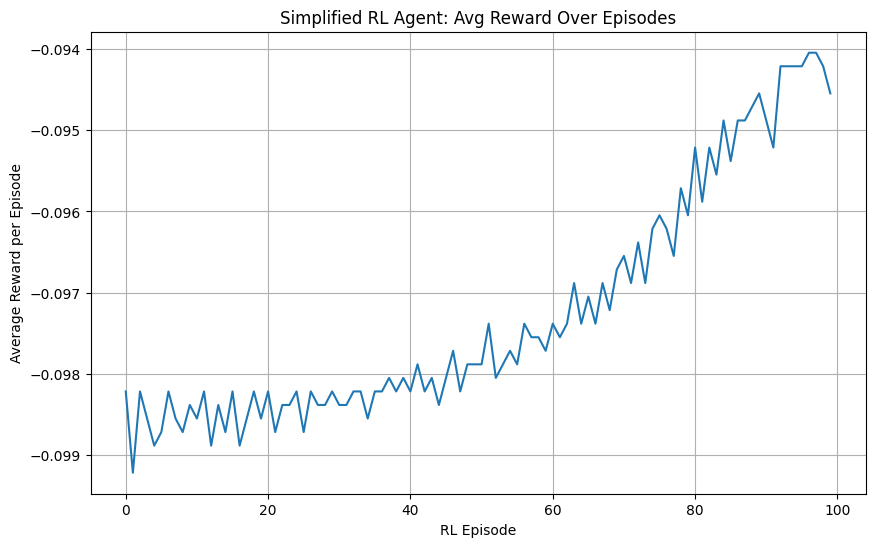

RL suggests Seq Length for 'low error' state: 24
RL suggests Seq Length for 'high error' state: 72


In [ ]:
# Cell 11: Simplified RL Training Loop (Conceptual)

# Load the pre-trained MSMVAN model
msmvan_rl_model = MSMVAN_Univariate(
    input_size=1, hidden_size_lstm=HIDDEN_SIZE_LSTM, lstm_layers=2,
    ffc_out_channels_total=FDCNN_OUT_CHANNELS, attention_units=ATTENTION_UNITS,
    pred_horizon=PREDICTION_HORIZON, seq_len=SEQ_LENGTH, # Original SEQ_LENGTH
    dropout_rate=DROPOUT_RATE
).to(DEVICE)
msmvan_rl_model.load_state_dict(torch.load('best_msmvan_colab_model.pth'))
msmvan_rl_model.eval() # Set to evaluation mode

# Use criterion from MSMVAN training
msmvan_criterion = nn.MSELoss()

# We need some data to simulate MSMVAN performance. Use test_loader.
if not test_loader:
    print("RL Demo: Test loader is empty. Cannot run RL simulation.")
else:
    rl_episode_rewards = []
    # Placeholder for recent MSMVAN error to determine RL state
    # In a real scenario, this would be updated based on actual MSMVAN performance
    current_simulated_msmvan_error = 0.1 # Initial dummy error

    print("\n--- Starting Simplified RL Training (Conceptual) ---")
    for episode in range(NUM_RL_EPISODES):
        current_rl_state = get_rl_state(current_simulated_msmvan_error)
        episode_reward_sum = 0

        for step in range(NUM_RL_STEPS_PER_EPISODE):
            action_idx = choose_rl_action(current_rl_state, RL_EPSILON)
            chosen_seq_length_value = POSSIBLE_SEQ_LENGTHS[action_idx]

            # Get a batch of data for MSMVAN simulation
            # The MSMVAN model is fixed to its trained SEQ_LENGTH.
            # The RL agent *chooses* a conceptual seq_length, and the reward function
            # *simulates* or *penalizes* based on this choice relative to the model's fixed nature.
            # This is a major simplification.
            try:
                # Get a fixed batch from test_loader (input will always have original SEQ_LENGTH)
                rl_batch_features, rl_batch_targets = next(iter(test_loader))
            except StopIteration: # Reset iterator if test_loader is exhausted
                test_loader_iter = iter(test_loader)
                rl_batch_features, rl_batch_targets = next(test_loader_iter)


            # Simulate environment step
            # The core challenge: msmvan_rl_model expects input of shape (Batch, SEQ_LENGTH, 1)
            # If chosen_seq_length_value is different, we can't directly feed it.
            # For this demo, we pass the standard batch, and the reward function might
            # artificially consider the chosen_seq_length_value.
            reward, msvan_mse_for_step = simulate_msmvan_performance(
                chosen_seq_length_value,
                rl_batch_features, # This batch has the original SEQ_LENGTH
                rl_batch_targets,
                msmvan_rl_model,
                scaler, # The global scaler object
                msmvan_criterion,
                DEVICE
            )
            episode_reward_sum += reward
            current_simulated_msmvan_error = msvan_mse_for_step # Update simulated error

            # Q-table update (simplified)
            # For a real problem, the next_state would be based on the outcome of using chosen_seq_length_value
            next_rl_state = get_rl_state(current_simulated_msmvan_error)
            old_q_value = q_table[current_rl_state, action_idx]
            next_max_q = np.max(q_table[next_rl_state, :])

            new_q_value = (1 - RL_LEARNING_RATE) * old_q_value + \
                          RL_LEARNING_RATE * (reward + RL_DISCOUNT_FACTOR * next_max_q)
            q_table[current_rl_state, action_idx] = new_q_value

            current_rl_state = next_rl_state

        rl_episode_rewards.append(episode_reward_sum / NUM_RL_STEPS_PER_EPISODE)
        if (episode + 1) % 10 == 0:
            print(f"RL Episode {episode+1}/{NUM_RL_EPISODES}, Avg Reward: {episode_reward_sum / NUM_RL_STEPS_PER_EPISODE:.4f}, Current Epsilon: {RL_EPSILON:.2f}")

        # Decay epsilon (simple decay)
        if RL_EPSILON > 0.01:
            RL_EPSILON *= 0.99

    print("--- Simplified RL Training Finished ---")
    print("Learned Q-Table (State x Action):")
    print(q_table)

    # Plot RL rewards
    plt.figure(figsize=(10, 6))
    plt.plot(rl_episode_rewards)
    plt.xlabel("RL Episode")
    plt.ylabel("Average Reward per Episode")
    plt.title("Simplified RL Agent: Avg Reward Over Episodes")
    plt.grid(True)
    plt.savefig("simplified_rl_rewards.png")
    plt.show()

    # Example: Get optimal action for a given state
    optimal_action_low_error_state = np.argmax(q_table[0, :])
    optimal_seq_len_low_error = POSSIBLE_SEQ_LENGTHS[optimal_action_low_error_state]
    print(f"RL suggests Seq Length for 'low error' state: {optimal_seq_len_low_error}")

    optimal_action_high_error_state = np.argmax(q_table[1, :])
    optimal_seq_len_high_error = POSSIBLE_SEQ_LENGTHS[optimal_action_high_error_state]
    print(f"RL suggests Seq Length for 'high error' state: {optimal_seq_len_high_error}")